In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math, time
import datetime
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
# fixar random seed para se puder reproduzir os resultados
seed = 9
np.random.seed(seed)

Using TensorFlow backend.


# Etapa 1 - preparar o dataset

In [2]:
'''
fazer o download da sequencias do valor das ações da google GOOGL stock data (fonte yahoo.com)
dataset:
http://chart.finance.yahoo.com/table.csv?s=GOOGL&a=11&b=15&c=2011&d=29&e=10&f=2016&g=d&ignore=.csv
A função get_stock_data é generica para ir buscar dados à yahoo.com
trata-se uma tabela com: ['Date','Open','High','Low','Close','Volume','Adj Close']
Vamos śo utilizar os campos ['Open','High','Close']
'''
def get_stock_data(stock_name, normalized=0,file_name=None):
    if not file_name:
        file_name = 'http://chart.finance.yahoo.com/table.csv?s=%s&a=11&b=15&c=2011&d=29&e=10&f=2016&g=d&ignore=.csv' % stock_name
    col_names = ['Date','Open','High','Low','Close','Volume','Adj Close']
    stocks = pd.read_csv(file_name, header=0, names=col_names) #fica numa especie de tabela exactamente como estava no csv (1350 linhas,7 colunas)
    df = pd.DataFrame(stocks) #neste caso não vai fazer nada
    date_split = df['Date'].str.split('-').str #não vai servir para nada
    df['Year'], df['Month'], df['Day'] = date_split #não vai servir para nada
    df["Volume"] = df["Volume"] / 10000 #não vai servir para nada
    df.drop(df.columns[[0,3,5,6, 7,8,9]], axis=1, inplace=True) #vou só ficar com as colunas 1,2,4
    return df

In [3]:
def load_GOOGL_stock_dataset():
    stock_name = 'GOOGL'
    return get_stock_data(stock_name, 0, 'table.csv')

def pre_processar_GOOGL_stock_dataset(df):
    df['High'] = df['High'] / 100
    df['Open'] = df['Open'] / 100
    df['Close'] = df['Close'] / 100
    return df

# Visualizar os top registos da tabela
def visualize_GOOGL():
    df = load_GOOGL_stock_dataset()
    print('### Antes do pré-processamento ###')
    print(df.head()) #mostra só os primeiros 5 registos
    df = pre_processar_GOOGL_stock_dataset(df)
    print('### Após o pré-processamento ###')
    print(df.head())

In [4]:
#função load_data do lstm.py configurada para aceitar qualquer número de parametros
#o último atributo é que fica como label (resultado)
#stock é um dataframe do pandas (uma especie de dicionario + matriz)
#seq_len é o tamanho da janela a ser utilizada na serie temporal
def load_data(df_dados, janela):
    qt_atributos = len(df_dados.columns)
    mat_dados = df_dados.as_matrix() #converter dataframe para matriz (lista com lista de cada registo)
    tam_sequencia = janela + 1
    res = []
    for i in range(len(mat_dados) - tam_sequencia): #numero de registos - tamanho da sequencia
        res.append(mat_dados[i: i + tam_sequencia])
    res = np.array(res) #dá como resultado um np com uma lista de matrizes (janela deslizante ao longo da serie)
    qt_casos_treino = int(round(0.9 * res.shape[0])) #90% passam a ser casos de treino
    train = res[:qt_casos_treino, :]
    x_train = train[:, :-1] #menos um registo pois o ultimo registo é o registo a seguir à janela
    y_train = train[:, -1][:,-1] #para ir buscar o último atributo para a lista dos labels
    x_test = res[qt_casos_treino:, :-1]
    y_test = res[qt_casos_treino:, -1][:,-1]
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], qt_atributos))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], qt_atributos))
    return [x_train, y_train, x_test, y_test]

# Etapa 2 - Definir a topologia da rede (arquitectura do modelo) e compilar '''

In [5]:
def build_model2(janela):
    model = Sequential()
    model.add(LSTM(128, input_shape=(janela, 3), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64, input_shape=(janela, 3), return_sequences=False))
    #model.add(Dropout(0.2))
    model.add(Dense(16, activation="relu", kernel_initializer="uniform"))
    model.add(Dense(1, activation="linear", kernel_initializer="uniform"))
    model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
    return model

In [6]:
#imprime um grafico com os valores de teste e com as correspondentes tabela de previsões
def print_series_prediction(y_test,predic):
    diff=[]
    racio=[]
    for i in range(len(y_test)): #para imprimir tabela de previsoes
        racio.append( (y_test[i]/predic[i])-1)
        diff.append( abs(y_test[i]- predic[i]))
        print('valor: %f ---> Previsão: %f Diff: %f Racio: %f' % (y_test[i],predic[i], diff[i], racio[i]))
    plt.plot(y_test,color='blue', label='y_test')
    plt.plot(predic,color='red', label='prediction') #este deu uma linha em branco
    plt.plot(diff,color='green', label='diff')
    plt.plot(racio,color='yellow', label='racio')
    plt.legend(loc='upper left')
    plt.show()

In [7]:
def LSTM_utilizando_GOOGL_data():
    df = load_GOOGL_stock_dataset()
    df = pre_processar_GOOGL_stock_dataset(df)
    print("df", df.shape)
    janela = 22 #tamanho da Janela deslizante
    X_train, y_train, X_test, y_test = load_data(df[::-1], janela)# o df[::-1] é o df por ordem inversa
    print("X_train", X_train.shape)
    print("y_train", y_train.shape)
    print("X_test", X_test.shape)
    print("y_test", y_test.shape)
    #model = build_model(janela)
    model = build_model2(janela)
    #model.fit(X_train, y_train, batch_size=512, epochs=500, validation_split=0.1, verbose=1)
    model.fit(X_train, y_train, batch_size=512, epochs=500, validation_split=0.1, verbose=1)
    #print_model(model,"lstm_model.png")
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))
    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    print(model.metrics_names)
    p = model.predict(X_test)
    predic = np.squeeze(np.asarray(p)) #para transformar uma matriz de uma coluna e n linhas em 
    #um np array de n elementos
    print_series_prediction(y_test,predic)
    ''' 
    MSE- (Mean square error), RMSE- (root mean square error) –
    o significado de RMSE depende do range da label. para o mesmo range menor é melhor.
    '''

In [18]:
X_train.shape

(1194, 22, 3)

### Antes do pré-processamento ###
         Open        High       Close
0  929.000000  935.900024  924.520020
1  890.000000  893.380005  891.440002
2  891.390015  892.989990  889.140015
3  882.260010  892.250000  888.840027
4  868.440002  879.960022  878.929993
### Após o pré-processamento ###
     Open    High   Close
0  9.2900  9.3590  9.2452
1  8.9000  8.9338  8.9144
2  8.9139  8.9299  8.8914
3  8.8226  8.9225  8.8884
4  8.6844  8.7996  8.7893
df (1350, 3)
X_train (1194, 22, 3)
y_train (1194,)
X_test (133, 22, 3)
y_test (133,)
Train on 1074 samples, validate on 120 samples
Epoch 1/500
1074/1074 [==============================] - 2s 2ms/step - loss: 54.6266 - acc: 0.0000e+00 - val_loss: 57.6716 - val_acc: 0.0000e+00
Epoch 2/500
1074/1074 [==============================] - 0s 236us/step - loss: 54.2142 - acc: 0.0000e+00 - val_loss: 57.1725 - val_acc: 0.0000e+00
Epoch 3/500
1074/1074 [==============================] - 0s 236us/step - loss: 53.7332 - acc: 0.0000e+00 - val_loss: 56.5840

Epoch 53/500
1074/1074 [==============================] - 0s 231us/step - loss: 3.1117 - acc: 0.0000e+00 - val_loss: 0.3016 - val_acc: 0.0000e+00
Epoch 54/500
1074/1074 [==============================] - 0s 236us/step - loss: 3.1109 - acc: 0.0000e+00 - val_loss: 0.3097 - val_acc: 0.0000e+00
Epoch 55/500
1074/1074 [==============================] - 0s 234us/step - loss: 3.1101 - acc: 0.0000e+00 - val_loss: 0.3183 - val_acc: 0.0000e+00
Epoch 56/500
1074/1074 [==============================] - 0s 230us/step - loss: 3.1091 - acc: 0.0000e+00 - val_loss: 0.3226 - val_acc: 0.0000e+00
Epoch 57/500
1074/1074 [==============================] - 0s 232us/step - loss: 3.1089 - acc: 0.0000e+00 - val_loss: 0.3279 - val_acc: 0.0000e+00
Epoch 58/500
1074/1074 [==============================] - 0s 229us/step - loss: 3.1087 - acc: 0.0000e+00 - val_loss: 0.3333 - val_acc: 0.0000e+00
Epoch 59/500
1074/1074 [==============================] - 0s 231us/step - loss: 3.1084 - acc: 0.0000e+00 - val_loss: 0.3348 

1074/1074 [==============================] - 0s 236us/step - loss: 3.1099 - acc: 0.0000e+00 - val_loss: 0.3773 - val_acc: 0.0000e+00
Epoch 110/500
1074/1074 [==============================] - 0s 234us/step - loss: 3.1096 - acc: 0.0000e+00 - val_loss: 0.3718 - val_acc: 0.0000e+00
Epoch 111/500
1074/1074 [==============================] - 0s 231us/step - loss: 3.1088 - acc: 0.0000e+00 - val_loss: 0.3596 - val_acc: 0.0000e+00
Epoch 112/500
1074/1074 [==============================] - 0s 237us/step - loss: 3.1082 - acc: 0.0000e+00 - val_loss: 0.3499 - val_acc: 0.0000e+00
Epoch 113/500
1074/1074 [==============================] - 0s 230us/step - loss: 3.1091 - acc: 0.0000e+00 - val_loss: 0.3406 - val_acc: 0.0000e+00
Epoch 114/500
1074/1074 [==============================] - 0s 236us/step - loss: 3.1082 - acc: 0.0000e+00 - val_loss: 0.3437 - val_acc: 0.0000e+00
Epoch 115/500
1074/1074 [==============================] - 0s 232us/step - loss: 3.1081 - acc: 0.0000e+00 - val_loss: 0.3501 - val_a

Epoch 165/500
1074/1074 [==============================] - 0s 233us/step - loss: 3.1089 - acc: 0.0000e+00 - val_loss: 0.3098 - val_acc: 0.0000e+00
Epoch 166/500
1074/1074 [==============================] - 0s 231us/step - loss: 3.1099 - acc: 0.0000e+00 - val_loss: 0.3161 - val_acc: 0.0000e+00
Epoch 167/500
1074/1074 [==============================] - 0s 230us/step - loss: 3.1093 - acc: 0.0000e+00 - val_loss: 0.3363 - val_acc: 0.0000e+00
Epoch 168/500
1074/1074 [==============================] - 0s 231us/step - loss: 3.1080 - acc: 0.0000e+00 - val_loss: 0.3610 - val_acc: 0.0000e+00
Epoch 169/500
1074/1074 [==============================] - 0s 233us/step - loss: 3.1088 - acc: 0.0000e+00 - val_loss: 0.3721 - val_acc: 0.0000e+00
Epoch 170/500
1074/1074 [==============================] - 0s 232us/step - loss: 3.1093 - acc: 0.0000e+00 - val_loss: 0.3760 - val_acc: 0.0000e+00
Epoch 171/500
1074/1074 [==============================] - 0s 241us/step - loss: 3.1095 - acc: 0.0000e+00 - val_loss: 

Epoch 221/500
1074/1074 [==============================] - 0s 232us/step - loss: 3.1083 - acc: 0.0000e+00 - val_loss: 0.3312 - val_acc: 0.0000e+00
Epoch 222/500
1074/1074 [==============================] - 0s 231us/step - loss: 3.1091 - acc: 0.0000e+00 - val_loss: 0.3276 - val_acc: 0.0000e+00
Epoch 223/500
1074/1074 [==============================] - 0s 237us/step - loss: 3.1086 - acc: 0.0000e+00 - val_loss: 0.3317 - val_acc: 0.0000e+00
Epoch 224/500
1074/1074 [==============================] - 0s 237us/step - loss: 3.1084 - acc: 0.0000e+00 - val_loss: 0.3270 - val_acc: 0.0000e+00
Epoch 225/500
1074/1074 [==============================] - 0s 234us/step - loss: 3.1087 - acc: 0.0000e+00 - val_loss: 0.3275 - val_acc: 0.0000e+00
Epoch 226/500
1074/1074 [==============================] - 0s 235us/step - loss: 3.1086 - acc: 0.0000e+00 - val_loss: 0.3395 - val_acc: 0.0000e+00
Epoch 227/500
1074/1074 [==============================] - 0s 237us/step - loss: 3.1074 - acc: 0.0000e+00 - val_loss: 

Epoch 277/500
1074/1074 [==============================] - 0s 237us/step - loss: 3.1125 - acc: 0.0000e+00 - val_loss: 0.2999 - val_acc: 0.0000e+00
Epoch 278/500
1074/1074 [==============================] - 0s 237us/step - loss: 3.1112 - acc: 0.0000e+00 - val_loss: 0.3055 - val_acc: 0.0000e+00
Epoch 279/500
1074/1074 [==============================] - 0s 239us/step - loss: 3.1099 - acc: 0.0000e+00 - val_loss: 0.3231 - val_acc: 0.0000e+00
Epoch 280/500
1074/1074 [==============================] - 0s 237us/step - loss: 3.1082 - acc: 0.0000e+00 - val_loss: 0.3438 - val_acc: 0.0000e+00
Epoch 281/500
1074/1074 [==============================] - 0s 238us/step - loss: 3.1084 - acc: 0.0000e+00 - val_loss: 0.3549 - val_acc: 0.0000e+00
Epoch 282/500
1074/1074 [==============================] - 0s 238us/step - loss: 3.1084 - acc: 0.0000e+00 - val_loss: 0.3576 - val_acc: 0.0000e+00
Epoch 283/500
1074/1074 [==============================] - 0s 231us/step - loss: 3.1089 - acc: 0.0000e+00 - val_loss: 

Epoch 333/500
1074/1074 [==============================] - 0s 233us/step - loss: 3.1083 - acc: 0.0000e+00 - val_loss: 0.3274 - val_acc: 0.0000e+00
Epoch 334/500
1074/1074 [==============================] - 0s 231us/step - loss: 3.1087 - acc: 0.0000e+00 - val_loss: 0.3309 - val_acc: 0.0000e+00
Epoch 335/500
1074/1074 [==============================] - 0s 229us/step - loss: 3.1088 - acc: 0.0000e+00 - val_loss: 0.3417 - val_acc: 0.0000e+00
Epoch 336/500
1074/1074 [==============================] - 0s 233us/step - loss: 3.1077 - acc: 0.0000e+00 - val_loss: 0.3619 - val_acc: 0.0000e+00
Epoch 337/500
1074/1074 [==============================] - 0s 234us/step - loss: 3.1080 - acc: 0.0000e+00 - val_loss: 0.3910 - val_acc: 0.0000e+00
Epoch 338/500
1074/1074 [==============================] - 0s 233us/step - loss: 3.1122 - acc: 0.0000e+00 - val_loss: 0.4114 - val_acc: 0.0000e+00
Epoch 339/500
1074/1074 [==============================] - 0s 235us/step - loss: 3.1135 - acc: 0.0000e+00 - val_loss: 

Epoch 389/500
1074/1074 [==============================] - 0s 236us/step - loss: 3.1090 - acc: 0.0000e+00 - val_loss: 0.3504 - val_acc: 0.0000e+00
Epoch 390/500
1074/1074 [==============================] - 0s 234us/step - loss: 3.1082 - acc: 0.0000e+00 - val_loss: 0.3433 - val_acc: 0.0000e+00
Epoch 391/500
1074/1074 [==============================] - 0s 233us/step - loss: 3.1084 - acc: 0.0000e+00 - val_loss: 0.3397 - val_acc: 0.0000e+00
Epoch 392/500
1074/1074 [==============================] - 0s 237us/step - loss: 3.1088 - acc: 0.0000e+00 - val_loss: 0.3482 - val_acc: 0.0000e+00
Epoch 393/500
1074/1074 [==============================] - 0s 232us/step - loss: 3.1082 - acc: 0.0000e+00 - val_loss: 0.3567 - val_acc: 0.0000e+00
Epoch 394/500
1074/1074 [==============================] - 0s 231us/step - loss: 3.1102 - acc: 0.0000e+00 - val_loss: 0.3730 - val_acc: 0.0000e+00
Epoch 395/500
1074/1074 [==============================] - 0s 231us/step - loss: 3.1094 - acc: 0.0000e+00 - val_loss: 

Epoch 445/500
1074/1074 [==============================] - 0s 232us/step - loss: 3.1091 - acc: 0.0000e+00 - val_loss: 0.3714 - val_acc: 0.0000e+00
Epoch 446/500
1074/1074 [==============================] - 0s 232us/step - loss: 3.1090 - acc: 0.0000e+00 - val_loss: 0.3590 - val_acc: 0.0000e+00
Epoch 447/500
1074/1074 [==============================] - 0s 226us/step - loss: 3.1091 - acc: 0.0000e+00 - val_loss: 0.3401 - val_acc: 0.0000e+00
Epoch 448/500
1074/1074 [==============================] - 0s 226us/step - loss: 3.1082 - acc: 0.0000e+00 - val_loss: 0.3382 - val_acc: 0.0000e+00
Epoch 449/500
1074/1074 [==============================] - 0s 225us/step - loss: 3.1083 - acc: 0.0000e+00 - val_loss: 0.3460 - val_acc: 0.0000e+00
Epoch 450/500
1074/1074 [==============================] - 0s 227us/step - loss: 3.1084 - acc: 0.0000e+00 - val_loss: 0.3547 - val_acc: 0.0000e+00
Epoch 451/500
1074/1074 [==============================] - 0s 229us/step - loss: 3.1085 - acc: 0.0000e+00 - val_loss: 

Train Score: 2.83 MSE (1.68 RMSE)
Test Score: 1.28 MSE (1.13 RMSE)
['loss', 'acc']
valor: 8.068400 ---> Previsão: 7.170642 Diff: 0.897758 Racio: 0.125199
valor: 8.214900 ---> Previsão: 7.170642 Diff: 1.044258 Racio: 0.145630
valor: 8.268400 ---> Previsão: 7.170642 Diff: 1.097758 Racio: 0.153091
valor: 8.216300 ---> Previsão: 7.170642 Diff: 1.045658 Racio: 0.145825
valor: 8.240600 ---> Previsão: 7.170642 Diff: 1.069958 Racio: 0.149214
valor: 8.357400 ---> Previsão: 7.170642 Diff: 1.186758 Racio: 0.165502
valor: 8.285500 ---> Previsão: 7.170642 Diff: 1.114858 Racio: 0.155475
valor: 8.221000 ---> Previsão: 7.170642 Diff: 1.050358 Racio: 0.146480
valor: 8.173500 ---> Previsão: 7.170642 Diff: 1.002858 Racio: 0.139856
valor: 8.195600 ---> Previsão: 7.170642 Diff: 1.024958 Racio: 0.142938
valor: 8.099000 ---> Previsão: 7.170642 Diff: 0.928358 Racio: 0.129467
valor: 8.054800 ---> Previsão: 7.170642 Diff: 0.884158 Racio: 0.123302
valor: 7.884200 ---> Previsão: 7.170642 Diff: 0.713558 Racio: 0.0

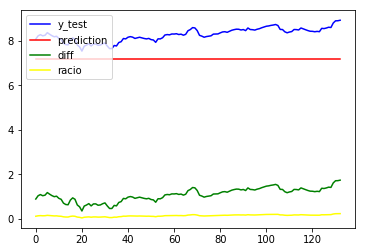

In [8]:
if __name__ == '__main__':
    visualize_GOOGL()
    df = load_GOOGL_stock_dataset()
    df = pre_processar_GOOGL_stock_dataset(df)
    print("df", df.shape)
    janela = 22 #tamanho da Janela deslizante
    X_train, y_train, X_test, y_test = load_data(df[::-1], janela)# o df[::-1] é o df por ordem inversa
    print("X_train", X_train.shape)
    print("y_train", y_train.shape)
    print("X_test", X_test.shape)
    print("y_test", y_test.shape)
    #model = build_model(janela)
    model = build_model2(janela)
    #model.fit(X_train, y_train, batch_size=512, epochs=500, validation_split=0.1, verbose=1)
    model.fit(X_train, y_train, batch_size=512, epochs=500, validation_split=0.1, verbose=1)
    #print_model(model,"lstm_model.png")
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))
    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    print(model.metrics_names)
    p = model.predict(X_test)
    predic = np.squeeze(np.asarray(p)) #para transformar uma matriz de uma coluna e n linhas em 
    #um np array de n elementos
    print_series_prediction(y_test,predic)
    ''' 
    MSE- (Mean square error), RMSE- (root mean square error) –
    o significado de RMSE depende do range da label. para o mesmo range menor é melhor.
    '''

In [9]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 22, 128)           67584     
_________________________________________________________________
dropout_1 (Dropout)          (None, 22, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 118,049
Trainable params: 118,049
Non-trainable params: 0
_________________________________________________________________
None
